沒有交易紀錄


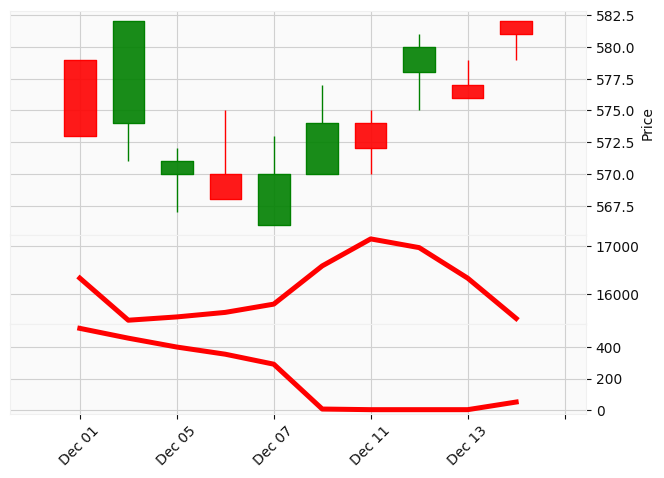

In [1]:
# 載入必要套件
from BackTest import ChartTrade, Performance
from FinMind.data import DataLoader
import pandas as pd
import mplfinance as mpf
import os
import yfinance as yf

datapath = "./"

# 載入FinMind 套件

FM = DataLoader()

"""自訂函數"""


# (3)取得資料 FinMind 資料來源
def getFMMarginTrading(prod, st, en):
    # 檔案路徑與名稱
    bakfile = f"{datapath}/{prod}_{st}_{en}_taiwan_stock_margin_purchase_short_sale.csv"
    # 假如檔案已經存在
    if os.path.exists(bakfile):
        # 取得檔案內容
        tmpdata = pd.read_csv(bakfile)
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
    # 沒有的話就取API內容
    else:
        tmpdata = FM.taiwan_stock_margin_purchase_short_sale(
            stock_id=prod, start_date=st, end_date=en
        )
        # 將日期設定為索引
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
        tmpdata.drop("date", axis=1, inplace=True)
        # 將API內容寫入備份檔中
        tmpdata.to_csv(bakfile)
    # 回傳資料
    return tmpdata


# (2)取得資料：本地或是 Yahoo
def getDataFM(prod, st, en):
    # 檔案路徑
    bakfile = f"data/YF_{prod}_{st}_{en}_stock_daily_adj.csv"
    # 假如已經有 Excel 資料檔案
    if os.path.exists(bakfile):
        # 讀取 Excel 資料檔案
        data = pd.read_csv(bakfile, index_col="Date", parse_dates=True)
    # 假如 Excel 資料檔案不存在
    else:
        # 透過 yf 下載
        data = yf.download(f"{prod}.TW", start=st, end=en)
        # 下載的資料是英文的，處理欄位名稱，轉換為小寫
        # 轉換部分不包含索引，所以日期還是大寫開頭的 Date
        data.columns = [i.lower() for i in data.columns]
        # 假如下載後沒有資料
        if data.empty:
            print("無法從 Yahoo Finance 下載資料")
            # 傳回一個空的 pd
            return pd.DataFrame()
        # 假如資料 data 不是空的，依照指定路徑存擋
        data.to_csv(bakfile)
    # 存檔後，傳回資料
    return data


# (1)取得資料
def getFMPriceAndMarginTrade(prod, st, en):
    # (2)取得資料：本地或是 Yahoo
    data1 = getDataFM(prod, st, en)
    data2 = getFMMarginTrading(prod, st, en)
    data3 = pd.concat([data1, data2], axis=1, join="inner")
    return data3


if __name__ == "__main__":
    # 證券代號
    prod = "2330"
    # 取得回測資料
    data = getFMPriceAndMarginTrade(prod, "2023-12-01", "2023-12-15")

    # 融資融券餘額
    data["mb"] = data["MarginPurchaseTodayBalance"].astype(int)
    data["ms"] = data["ShortSaleTodayBalance"].astype(int)
    data["mb_mean"] = data["mb"].rolling(20).mean()
    data["ms_mean"] = data["ms"].rolling(20).mean()

    # 初始部位
    position = 0
    trade = pd.DataFrame()
    # 開始回測
    for i in range(data.shape[0] - 1):
        # 取得策略會應用到的變數
        c_time = data.index[i]
        c_high = data.loc[c_time, "high"]
        c_close = data.loc[c_time, "close"]
        c_mb = data.loc[c_time, "mb"]
        c_mb_mean = data.loc[c_time, "mb_mean"]
        c_ms = data.loc[c_time, "ms"]
        c_ms_mean = data.loc[c_time, "ms_mean"]
        # 取下一期資料做為進場資料
        n_time = data.index[i + 1]
        n_open = data.loc[n_time, "open"]

        # 進場程序
        if position == 0:
            if c_mb < c_mb_mean * 0.99 and c_ms > c_ms_mean * 1.01:
                position = 1
                order_i = i
                order_time = n_time
                order_price = n_open
                order_unit = 1
        # 出場程序
        elif position == 1:
            # 出場邏輯
            if c_ms < c_ms_mean:
                position = 0
                cover_time = n_time
                cover_price = n_open
                # 交易紀錄
                trade = trade._append(
                    pd.Series(
                        [
                            prod,
                            "Buy",
                            order_time,
                            order_price,
                            cover_time,
                            cover_price,
                            order_unit,
                        ]
                    ),
                    ignore_index=True,
                )

    # 繪製副圖
    addp = []
    # 外資買賣力道
    addp.append(mpf.make_addplot(data["mb"], panel=1, color="red", secondary_y=False))
    # addp.append(mpf.make_addplot(data['mb_mean'],panel=1,color='blue',secondary_y=False))
    addp.append(mpf.make_addplot(data["ms"], panel=2, color="red", secondary_y=False))
    # addp.append(mpf.make_addplot(data['ms_mean'],panel=2,color='blue',secondary_y=False))

    # 績效分析
    Performance(trade, "Stock")
    # 繪製K線圖與交易明細
    ChartTrade(data, trade, addp=addp, v_enable=False)
